# Brain Volume Experiment
This notebook contains the code for the semi-synthetic data experiment that I conducted on a brain volume dataset.

In [1]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')

import cox
from cox.store import Store
from cox.readers import CollectionReader
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import r2_score
import os
import datetime
from sklearn.datasets import load_boston
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D 
import subprocess
import IPython
import matplotlib.patches as mpatches

from delphi import oracle 
from delphi.stats.truncated_linear_regression import TruncatedLinearRegression
from delphi.utils.helpers import Parameters

TABLE_NAME = 'logs'
COMMAND = 'RScript'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

In [2]:
def run_experiment(args, X, y):    
    # ground_truth parameters
    gt = LinearRegression() 
    gt.fit(X, y)
    gt_params = ch.from_numpy(np.concatenate([gt.coef_.flatten() ,gt.intercept_]))
    gt_var = ch.from_numpy(np.var(gt.predict(X) - y.numpy(), 0))
    
    schema = { 'known_r2': float,
            'known_param_mse': float,
            'known_epsilon': float,
            'known_time': int,
            'unknown_param_mse': float,
            'unknown_var_l1': float,
            'unknown_epsilon': float,
            'unknown_r2': float,
            'unknown_time': int,
            'ols_r2': float, 
            'ols_param_mse': float,
            'ols_var_l1': float,
            'ols_epsilon': float,
            'trunc_reg_param_mse': float, 
            'trunc_reg_var_l1': float,
            'trunc_reg_epsilon': float,
            'trunc_reg_r2': float,
            'trunc_reg_time': int,
            'alpha': float, 
            'c': float, 
            'num_samples': int}

    # variables for tracking best and worst trials

    C = [-2, -1, -.5, 0, .25, .5, .75, 1]
    for i in range(args.trials):
        # create store
        store = Store(args.out_dir + args.exp)
        store.add_table('logs', schema)

        for c in C: 
            # truncate
            phi = oracle.Left_Regression(c)
            indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
            x_trunc, y_trunc = X[indices], y[indices]
            # add survival probability to hyperparameters
            alpha = x_trunc.size(0) / X.size(0)

            y_trunc_mu = y_trunc.mean(0)

            # empirical linear regression
            ols = LinearRegression() 
            ols.fit(x_trunc, y_trunc)
            emp_noise_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[...,None]
            ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
            ols_param_mse = ch.sqrt(mse_loss(ols_params, gt_params))
            ols_var_l1 =  ch.abs(emp_noise_var - gt_var)
    
            # ols results
            store['logs'].update_row({
                'ols_r2': r2_score(y.flatten(), ols.predict(X).flatten()), 
                'ols_var_l1': ols_var_l1,
                'ols_param_mse': ols_param_mse,
                'ols_epsilon': ols_param_mse + ols_var_l1,
            })

            # normalize input data, so that assumption for algorithm is satisfied
            beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
            x_trunc_norm = x_trunc / beta

            # scale by the known noise variance 
            y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)        
            scaled_phi = oracle.Left_Regression((phi.left - y_trunc_mu) / ch.sqrt(gt_var))
            known_train_kwargs = Parameters({'phi': scaled_phi,
                                               'alpha': alpha, 
                                               'normalize': False,
                                               'batch_size': 10,
                                               'noise_var': 1.0,
                                               'epochs': 2})
            st = datetime.datetime.now()
            known_trunc_reg = TruncatedLinearRegression(known_train_kwargs)
            known_trunc_reg.fit(x_trunc_norm, y_trunc_scaled)
            end = datetime.datetime.now()

            w, w0 = (known_trunc_reg.coef_ * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept_ * ch.sqrt(gt_var) + y_trunc_mu 
            known_params = ch.cat([w.flatten(), w0])
            known_param_mse = ch.sqrt(mse_loss(known_params, gt_params))
            # known results
            store['logs'].update_row({
                'known_r2': r2_score(y.flatten(), X@w.T + w0), 
                'known_param_mse': known_param_mse,
                'known_time': (end - st).seconds, 
                'known_epsilon': known_param_mse,
            })


            emp_scaled_phi = oracle.Left_Regression((phi.left - y_trunc_mu) / ch.sqrt(emp_noise_var))
            y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_noise_var)
            unknown_train_kwargs = Parameters({'phi': emp_scaled_phi,
                                               'alpha': alpha, 
                                               'normalize': False,
                                               'batch_size': 10,
                                               'epochs': 2})
            st = datetime.datetime.now()
            unknown_trunc_reg = TruncatedLinearRegression(unknown_train_kwargs)
            unknown_trunc_reg.fit(x_trunc_norm, y_trunc_emp_scaled)
            end = datetime.datetime.now()

            w, w0 = (unknown_trunc_reg.coef_ * ch.sqrt(emp_noise_var)) / beta, unknown_trunc_reg.intercept_ * ch.sqrt(emp_noise_var) + y_trunc_mu
            unknown_params = ch.cat([w.flatten(), w0.flatten()])
            unknown_param_mse = ch.sqrt(mse_loss(unknown_params, gt_params))
            unknown_var_l1 = ch.abs(unknown_trunc_reg.variance * emp_noise_var - gt_var)
            # known results
            store['logs'].update_row({
                'unknown_r2': r2_score(y.flatten(), X@w.T + w0), 
                'unknown_param_mse': unknown_param_mse,
                'unknown_time': (end - st).seconds, 
                'unknown_var_l1': unknown_var_l1,
                'unknown_epsilon': unknown_param_mse + unknown_var_l1,
            })

            # spawn subprocess to run truncreg experiment
            concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
            """
            DATA FORMAT:
                -First n-1 columns are independent variables
                -nth column is dependent variable
            """
            concat_df = pd.DataFrame(concat)
            concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
            """
            Arguments
            - c - truncation point (float)
            - dir - left or right -> type of truncation (str)
            """
            cmd = ['Rscript', './truncreg.R'] + [str(c), str(x_trunc.size(1)), 'left', args.out_dir]

            # check_output will run the command and store the result
            st = datetime.datetime.now()
            result = subprocess.check_output(cmd, universal_newlines=True)
            trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
            trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])
            trunc_reg_pred = X@trunc_reg_params[:-1].T + trunc_reg_params[-1]
            trunc_reg_param_mse = ch.sqrt(mse_loss(trunc_reg_params, gt_params))
            trunc_reg_var_l1 = ch.abs(trunc_res[-1].pow(2)[None,...] - gt_var)

            # truncreg results
            store['logs'].update_row({
                'trunc_reg_r2': r2_score(y.flatten(), trunc_reg_pred.flatten()), 
                'trunc_reg_param_mse': trunc_reg_param_mse,
                'trunc_reg_var_l1': trunc_reg_var_l1,
                'trunc_reg_time': int((datetime.datetime.now() - st).total_seconds()), 
                'trunc_reg_epsilon': trunc_reg_param_mse + trunc_reg_var_l1,
            })   

            store['logs'].append_row({ 
                'alpha': float(alpha), 
                'c': c,    
                'num_samples': x_trunc.size(0),
            })

            IPython.display.clear_output()

        # close current store
        store.close()

In [3]:
args = Parameters({
    "trials": 5,
    "table_name": 'results', 
    "out_dir": '/Users/patroklos/Desktop/brain_volume/', # where to write results to
    "dataset": './df_meeting_Dec22.csv',
    "exp": 'first_trial', # experiment name
    "exp": 'less_than_one', # experiment name
    "exp": 'four_features', # experiment name
    "exp": 'four_features_again_', # experiment name
    "exp": 'test' # experiment name


})

# Import Dataset into Notebook
The fist thing that we nned to do is import the dataset. To do this, you can either provide the path to your dataset, including the filename to the $\textit{dataset}$ key of the args dictionary.

In [4]:
df = pd.read_csv(args.dataset)
df.head()

,eid,age,age65,age55,sex,repeated,apoe,y_brain_volume
0,1000031,70,1,1,0,0,0,-0.468900
1,1000193,53,0,0,0,0,0,0.380008
2,1000335,61,0,1,0,0,0,-0.312677
3,1000432,56,0,1,0,0,0,0.615299
4,1000602,58,0,1,0,0,1,1.418553


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35939 entries, 0 to 35938
Data columns (total 8 columns):
eid               35939 non-null int64
age               35939 non-null int64
age65             35939 non-null int64
age55             35939 non-null int64
sex               35939 non-null int64
repeated          35939 non-null int64
apoe              35939 non-null int64
y_brain_volume    35939 non-null float64
dtypes: float64(1), int64(7)
memory usage: 2.2 MB


# Data Exploration
For this regression task, we want to predict the PM10 concentratioin in the air at the specific time of a day. PM concentration is measure of the particulate matter in the air that has a diameter of less that 10 micrometers. And particulate matter is everything in the air that is not a gas and therefore consists of a huge variety of chemical compounds and materials. Now, the first thing that we want to do after extracting our data from csv file, is check whether our dependent variable is normally distibuted. When we plot our histogram, we see that in fact is normally distributed.

Now, that we know that our dependent variable is normally distributed, the next step is extracting the features that we want to use for our inputs. To do this, we want to determine which independent variables have a correlation with the PM10 concentration. The first thing that we do is create a correlation matrix to see the Pearson correlation's that the independent variables have with respect to one another.

In [6]:
corr_matrix = df.corr()
corr_matrix

,eid,age,age65,age55,sex,repeated,apoe,y_brain_volume
eid,1.000000,0.003337,0.003550,0.002335,-0.010448,0.010715,0.006162,-0.013309
age,0.003337,1.000000,0.830867,0.684794,0.091808,-0.062142,0.010285,-0.369341
age65,0.003550,0.830867,1.000000,0.411406,0.087531,-0.053131,0.006892,-0.308344
age55,0.002335,0.684794,0.411406,1.000000,0.036956,-0.037209,0.004932,-0.254792
sex,-0.010448,0.091808,0.087531,0.036956,1.000000,0.005595,-0.001780,0.433551
repeated,0.010715,-0.062142,-0.053131,-0.037209,0.005595,1.000000,-0.005403,0.036518
apoe,0.006162,0.010285,0.006892,0.004932,-0.001780,-0.005403,1.000000,-0.017190
y_brain_volume,-0.013309,-0.369341,-0.308344,-0.254792,0.433551,0.036518,-0.017190,1.000000


After examining the correlation matrix, we notice that the features taht are the most correlated to the PM10 concentration are cars per hour and wind speed. Further, we see that windspeed and cars per hour have a correlation of .186776, which is very small. Implying that there there are no multicollinearity issue with our regression setup. We now create a pairplot to further evaluate relationships between the features.

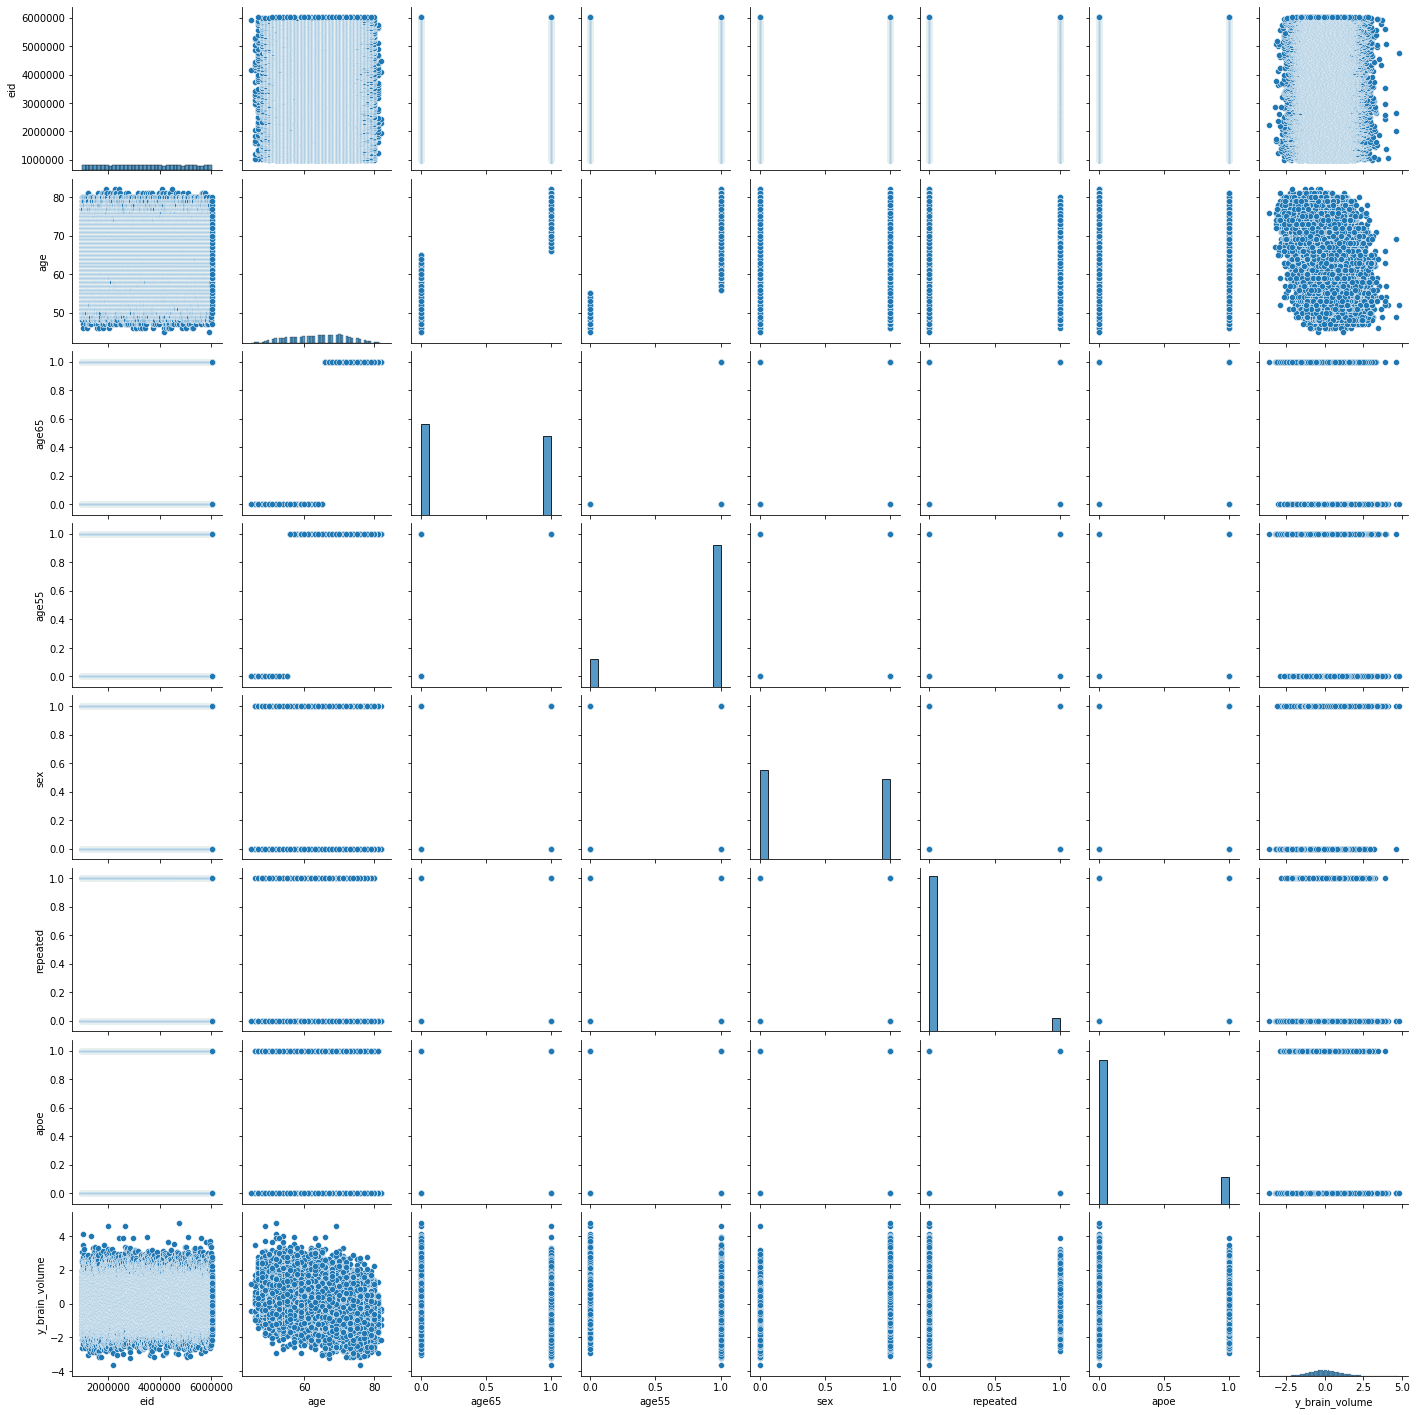

In [7]:
sns.pairplot(df)

After evaluating the pairplot, we can determine what features we will use for ground-truth untruncated regression. We will first set up our untruncated regression with $\textit{age}$ as our input feature, and $\textit{y_brain_volume}$ as our prediction task.

When we look at the $R^2$ of our original regression, we notice that is not that high $.13$. However, we only need our residuals to be normally distributed for our framework to work.

In [10]:
X, y = Tensor(df[['age']].to_numpy()), Tensor(df['y_brain_volume'].to_numpy()[...,None])
gt_ols = LinearRegression()
gt_ols.fit(X, y)
score = gt_ols.score(X, y)
print("R^2: ", score)
gt_var = (y - gt_ols.predict(X)).var(0)
print('ground-truth variance: ', float(gt_var))
gt_ = ch.from_numpy(np.concatenate([gt_ols.coef_.flatten(), gt_ols.intercept_]))

# fig = plt.figure(figsize=(10, 10))
# ax = fig.gca(projection='3d')

# x_max, x_min = X.max(0)[0], X.min(0)[0]
# X_ = np.arange(x_min[0], x_max[0], .1)
# Y = np.arange(x_min[1], x_max[1], .1)
# X_, Y = np.meshgrid(X_, Y) 


# actual = Tensor([])
# for i in range(X_.shape[0]): 
#     input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
#     actual = ch.cat([actual, Tensor(gt_ols.predict(input_))], 1)
# ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue', label='ground truth')
# ax.set_xlabel('Cars Per Hour')
# ax.set_ylabel('Wind Speed')
# ax.set_zlabel('PM10 Concentration')
# ax.scatter3D(X[:,0], X[:,1], y, color='grey', label='S', alpha=.4)
# ax.view_init(0, 45)

R^2:  0.13641255365929694
ground-truth variance:  0.8491442203521729


# Truncate Ground-Truth Regression
We now truncate our dataset, by applying left truncation at some point. Left truncation consists of removing all $(x_{i}, y_{i})$ pairs, whose $y_{i}$ falls below the threshold $C$. We first truncate our dataset at $C=1.0$. When we truncate, notice that only $16%$ of the original samples survive. I call this the survival probability, and declare it as $\alpha$. We then plot what the truncation does to our underlying regression. When plotting the new truncated regression, we notice that both the $R^{2}$ and the empirirical noise variance were biased by the imposed truncation.

alpha:  0.16536353265255016
r^2:  -2.179826982406811
empirical variance:  0.22304944694042206
trunc mse:  tensor(0.3437)
trunc var l1:  tensor([0.6261])
trunc ols r2:  -2.179826982406811


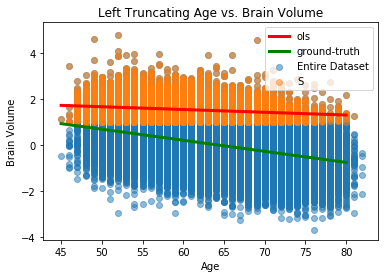

In [160]:
phi = oracle.Left_Regression(1.0)
indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = X[indices], y[indices]
alpha = x_trunc.size(0) / X.size(0)
print("alpha: ", alpha)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc) 
score = trunc_ols.score(X, y)
print("r^2: ", score)
emp_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
print('empirical variance: ', float(emp_var))
emp_ = ch.from_numpy(np.concatenate([trunc_ols.coef_.flatten(), trunc_ols.intercept_]))

trunc_mse = mse_loss(emp_, gt_)
print("trunc mse: ", trunc_mse)
trunc_var_l1 = abs(emp_var - gt_var)
print("trunc var l1: ", trunc_var_l1)
trunc_r2 = r2_score(y, X@trunc_ols.coef_ + trunc_ols.intercept_)
print("trunc ols r2: ", trunc_r2)

plt.scatter(X, y, alpha=.5, label='Entire Dataset')
plt.scatter(x_trunc, y_trunc, alpha=.5, label='S')
data = ch.linspace(45, 80, 100)[...,None]
plt.plot(data, data@trunc_ols.coef_ + trunc_ols.intercept_, color='red', label='ols', linewidth=3.0)
plt.plot(data, data@gt_ols.coef_ + gt_ols.intercept_, color='green', label='ground-truth', linewidth=3.0)
plt.xlabel('Age')
plt.ylabel('Brain Volume')
plt.title('Left Truncating Age vs. Brain Volume')
plt.legend()

We will first try to remove bias from the regression assuming that the noise variance of our untruncated dataset is the ground-truth noise variance of the linear regression problem. To do this, we standardize our dependent variable and other truncation set by the noise variance that we receive when we impose no truncation on our dataset. 

NOTE: since we normalize our input features and standardize our dependent variable, we need to make sure that reverse the applied transformation when our procedure is complete. To do this multiply our weight vector and intercept by the untruncated noise variance, we also divide our weight vector by our beta constant, and add the mean our truncated dependet variable to our intercept.

In [161]:
data = ch.linspace(0, 0, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)
y_scaled = (y - y_trunc_mu) / ch.sqrt(gt_var)

# normalize input data, so that assumption for algorithm is satisfied
beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
x_trunc_norm = x_trunc / beta

In [162]:
# standardize the left truncation oracle
scaled_phi = oracle.Left_Regression((phi.left - y_trunc_mu) / ch.sqrt(gt_var))
train_kwargs = Parameters({'phi': scaled_phi,
                           'alpha': alpha, 
                           'normalize': False,
                           'batch_size': 10,
                           'noise_var': 1.0,
                           'epochs': 10})
known_trunc_reg = TruncatedLinearRegression(train_kwargs)
known_trunc_reg.fit(x_trunc_norm, y_trunc_scaled)
known_w, known_w0 = (known_trunc_reg.coef_ * ch.sqrt(gt_var)) / beta, (known_trunc_reg.intercept_ * ch.sqrt(gt_var) + y_trunc_mu)
known_ = ch.cat([known_w.flatten(), known_w0])

known_mse = mse_loss(known_, gt_)
print("known_mse: ", known_mse)
known_r2 = r2_score(y, X@known_w + known_w0)
print("known variance r2: ", known_r2)

known_mse:  tensor(0.8290)
known variance r2:  0.03202972092008727


In [163]:
emp_scaled_phi = oracle.Left_Regression((phi.left - y_trunc_mu) / ch.sqrt(emp_var))
y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_var)
train_kwargs = Parameters({'phi': emp_scaled_phi,
                           'alpha': alpha, 
                           'normalize': False,
                           'batch_size': 10,
                          'epochs': 5})
unknown_trunc_reg = TruncatedLinearRegression(train_kwargs)
unknown_trunc_reg.fit(x_trunc_norm, y_trunc_emp_scaled)
unknown_w, unknown_w0 = (unknown_trunc_reg.coef_ * ch.sqrt(emp_var)) / beta, unknown_trunc_reg.intercept_ * ch.sqrt(emp_var) + y_trunc_mu
unknown_var = unknown_trunc_reg.variance_ * emp_var
unknown_ = ch.cat([unknown_w.flatten(), unknown_w0])

unknown_mse = mse_loss(unknown_, gt_)
print("unknown variance mse: ", unknown_mse)
unknown_var_l1 = abs(unknown_var - gt_var)
print("unknown variance l1: ", unknown_var_l1)
unknown_r2 = r2_score(y, X@unknown_w + unknown_w0)
print("unknown variance r2: ", unknown_r2)

unknown variance mse:  tensor(0.0375)
unknown variance l1:  tensor([[0.0166]])
unknown variance r2:  0.09549976415514316


We now spawn a subprocess and fit the same regression on \textit{truncreg}.

In [165]:
# spawn subprocess to run truncreg experiment
concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()

if not os.path.isdir(args.out_dir): 
    os.mkdir(args.out_dir)
"""
DATA FORMAT:
    -First n-1 columns are independent variables
    -nth column is dependent variable
"""
concat_df = pd.DataFrame(concat)
concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
"""
Arguments
- c - truncation point (float)
- dir - left or right -> type of truncation (str)
"""
cmd = [COMMAND, PATH2SCRIPT] + [str(phi.left), str(x_trunc.size(1)), 'left', args.out_dir]

# check_output will run the command and store the result
st = datetime.datetime.now()
result = subprocess.check_output(cmd, universal_newlines=True)
trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]

trunc_reg_mse = mse_loss(trunc_reg_params, gt_)
print("trunc reg mse: ", trunc_reg_mse)
trunc_reg_var_l1 = abs(trunc_res[-1].pow(2)[None,...] - gt_var)
print("trunc reg variance l1: ", trunc_reg_var_l1)

trunc reg mse:  tensor(0.1592)
trunc reg variance l1:  tensor([0.2563])


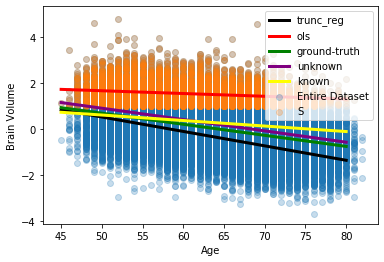

In [166]:
plt.scatter(X, y, alpha=.25, label='Entire Dataset')
plt.scatter(x_trunc, y_trunc, alpha=.25, label='S')
data = ch.linspace(45, 80, 100)[...,None]
plt.plot(data, data@trunc_reg_params[:-1] + trunc_reg_params[-1], label='trunc_reg', color='black', linewidth=3.0)
plt.plot(data, data@trunc_ols.coef_ + trunc_ols.intercept_, color='red', label='ols', linewidth=3.0)
plt.plot(data, data@gt_ols.coef_ + gt_ols.intercept_, color='green', label='ground-truth', linewidth=3.0)
plt.plot(data, data@unknown_w + unknown_w0, label='unknown', color='purple', linewidth=3.0)
plt.plot(data, data@known_w + known_w0, label='known', color='yellow', linewidth=3.0)
plt.xlabel('Age')
plt.ylabel('Brain Volume')
plt.legend()

We now plot all of the estimates on the figure to see how the various estimation techniques compare. We show that all three techniques removes bias from the original biased OLS estiamtes. 

# Run Experiment

In [273]:
run_experiment(args, X, y)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Logging in: /Users/patroklos/Desktop/brain_volume/test/7fcc706c-2a0c-4629-a22b-2be07a52201b
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorboardX/record_writer.py", line 58, in open_file
KeyError: '/Users/patroklos/Desktop/brain_volume/test/7fcc706c-2a0c-4629-a22b-2be07a52201b/tensorboard/events.out.tfevents.1641319313.Patrokloss-MacBook-Pro-2.local'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-273-6a2dd37d5fa2>", line 1, in <module>
    run_experiment(args, X, y)
  File "<ipython-input-270-b03ba1a7b190>", line 35, in run_experiment
    store = Store(args.out_dir + args.exp)
  File "/opt/anaconda3/lib/python3.7/site-packages/cox-0.1.post3-py3.7.egg/cox/store.py", line 102, in __init__
    self.tensor

TypeError: can only concatenate str (not "list") to str

# Results

In [203]:
reader = CollectionReader(args.out_dir + args.exp)
logs = reader.df('logs')
logs.head()

100%|██████████| 5/5 [00:00<00:00, 111.78it/s]


,known_r2,known_param_mse,known_time,unknown_param_mse,unknown_var_l1,unknown_r2,unknown_time,ols_r2,ols_param_mse,ols_var_l1,trunc_reg_param_mse,trunc_reg_var_l1,trunc_reg_r2,trunc_reg_time,alpha,c,num_samples,exp_id
0,0.133430,0.104395,9,0.005078,0.054858,0.136072,16,0.134734,0.018625,0.051074,0.002324,0.043872,0.135799,1,0.985002,-2.00,35400,c3e3a530-af74-4fb2-9c98-d8e8828e44a3
1,0.127502,0.305373,8,0.000018,0.118926,0.126756,14,0.062174,0.323515,0.237102,0.002660,0.126836,0.128845,1,0.847853,-1.00,30471,c3e3a530-af74-4fb2-9c98-d8e8828e44a3
2,0.117570,0.459335,7,0.000010,0.121750,0.133082,12,-0.114910,0.546242,0.358995,0.001966,0.159345,0.121759,1,0.690058,-0.50,24800,c3e3a530-af74-4fb2-9c98-d8e8828e44a3
3,0.098274,0.607235,4,0.007593,0.084519,0.134524,8,-0.498474,0.602202,0.471032,0.008737,0.157708,0.120522,0,0.495312,0.00,17801,c3e3a530-af74-4fb2-9c98-d8e8828e44a3
4,0.088302,0.748614,3,0.006505,0.069316,0.134292,7,-0.791131,0.581145,0.518054,0.017704,0.168590,0.113678,0,0.399121,0.25,14344,c3e3a530-af74-4fb2-9c98-d8e8828e44a3


# Plot Results

In [204]:
# # mutate the data frame to add additional logging info
# logs['unknown_param_mse'] = logs['unknown_param_mse'] ** (.5)
# logs['known_param_mse'] = logs['known_param_mse'] ** (.5)
# logs['trunc_reg_param_mse'] = logs['trunc_reg_param_mse'] ** (.5)
# logs['ols_param_mse'] = logs['ols_param_mse'] ** (.5)

# logs['unknown_epsilon'] = logs['unknown_param_mse'] + logs['unknown_var_l1']
# logs['known_epsilon'] = logs['known_param_mse']
# logs['trunc_reg_epsilon'] = logs['trunc_reg_param_mse'] + logs['trunc_reg_var_l1']
# logs['ols_epsilon'] = logs['ols_param_mse'] + logs['ols_var_l1']

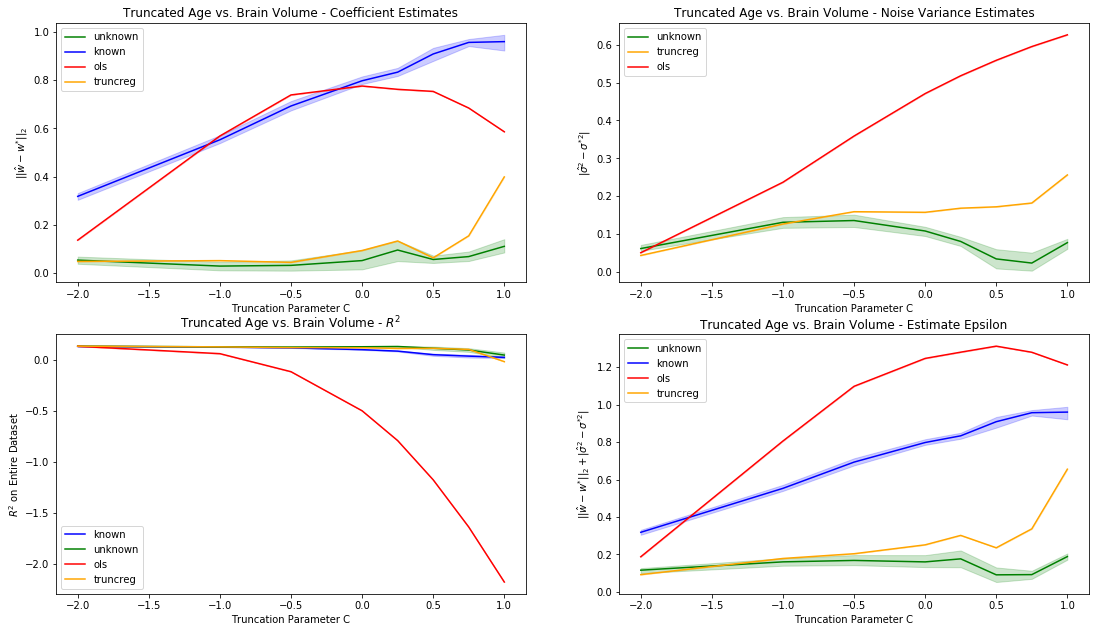

In [205]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)
# plot results for regression parameter MSE
sns.lineplot(data=logs, x='c', y='unknown_param_mse', label='unknown', color='green', ax=ax[0,0])
sns.lineplot(data=logs, x='c', y='known_param_mse', color='blue', label='known', ax=ax[0,0])
sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols', color='red', ax=ax[0,0])
sns.lineplot(data=logs, x='c', y='trunc_reg_param_mse', label='truncreg', color='orange', ax=ax[0,0])
ax[0,0].set_xlabel('Truncation Parameter C')
ax[0,0].set_ylabel('$||\hat w - w^{*}||_{2}$')
ax[0,0].set_title('Truncated Age vs. Brain Volume - Coefficient Estimates')

# plot results for regression noise variance l1
sns.lineplot(data=logs, x='c', y='unknown_var_l1', label='unknown', color="green", ax=ax[0,1])
sns.lineplot(data=logs, x='c', y='trunc_reg_var_l1', label='truncreg', color='orange', ax=ax[0,1])
sns.lineplot(data=logs, x='c', y='ols_var_l1', label='ols', color="red", ax=ax[0,1])
ax[0,1].set_xlabel('Truncation Parameter C')
ax[0,1].set_ylabel('$|\hat \sigma^{2} - \sigma^{*2}|$')
ax[0,1].set_title('Truncated Age vs. Brain Volume - Noise Variance Estimates')

# plot results for regression R^2
sns.lineplot(data=logs, x='c', y='known_r2', label='known', color='blue', ax=ax[1,0])
sns.lineplot(data=logs, x='c', y='unknown_r2', label='unknown', color='green', ax=ax[1,0])
sns.lineplot(data=logs, x='c', y='ols_r2', label='ols', color='red', ax=ax[1,0])
sns.lineplot(data=logs, x='c', y='trunc_reg_r2', label='truncreg', color='orange', ax=ax[1,0])
ax[1,0].set_xlabel('Truncation Parameter C')
ax[1,0].set_ylabel('$R^{2}$ on Entire Dataset')
ax[1,0].set_title('Truncated Age vs. Brain Volume - $R^{2}$')

# plot results for regression parameter epsilon 
sns.lineplot(data=logs, x='c', y='unknown_epsilon', label='unknown', color='green', ax=ax[1,1])
sns.lineplot(data=logs, x='c', y='known_epsilon', color='blue', label='known', ax=ax[1,1])
sns.lineplot(data=logs, x='c', y='ols_epsilon', label='ols', color='red', ax=ax[1,1])
sns.lineplot(data=logs, x='c', y='trunc_reg_epsilon', label='truncreg', color='orange', ax=ax[1,1])
ax[1,1].set_xlabel('Truncation Parameter C')
ax[1,1].set_ylabel('$||\hat w - w^{*}||_{2} + |\hat \sigma^{2} - \sigma^{*2}|$')
ax[1,1].set_title('Truncated Age vs. Brain Volume - Estimate Epsilon')
plt.show()

# Truncated Regression with Multiple Features
Now, we do the same procedure, however we will truncated the regression that we receive with multiple input features. For this experiment, we will use all of the features in the brain volume dataset. 

In [11]:
input_df = df[['age', 'apoe', 'sex', 'repeated']]
X = ch.from_numpy(input_df.to_numpy()).float()
print("Input Features: {}".format(input_df.columns))

Input Features: Index(['age', 'apoe', 'sex', 'repeated'], dtype='object')


In [12]:
gt_ols = LinearRegression()
gt_ols.fit(X, y)
score = gt_ols.score(X, y)
print("R^2: ", score)
gt_var = (y - gt_ols.predict(X)).var(0)
print('ground-truth variance: ', float(gt_var))
gt_ = ch.from_numpy(np.concatenate([gt_ols.coef_.flatten(), gt_ols.intercept_]))

R^2:  0.35700195148839975
ground-truth variance:  0.6322441101074219


In [13]:
phi = oracle.Left_Regression(1.0)
indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = X[indices], y[indices]
alpha = x_trunc.size(0) / X.size(0)
print("alpha: ", alpha)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc) 
score = trunc_ols.score(X, y)
print("r^2: ", score)
emp_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
print('empirical variance: ', float(emp_var))
emp_ = ch.from_numpy(np.concatenate([trunc_ols.coef_.flatten(), trunc_ols.intercept_]))

trunc_mse = mse_loss(emp_, gt_)
print("trunc mse: ", trunc_mse)
trunc_var_l1 = abs(emp_var - gt_var)
print("trunc var l1: ", trunc_var_l1)
trunc_r2 = r2_score(y, X@trunc_ols.coef_.T + trunc_ols.intercept_)
print("trunc ols r2: ", trunc_r2)

alpha:  0.16536353265255016
r^2:  -1.8115734915444355
empirical variance:  0.21523183584213257
trunc mse:  tensor(0.2235)
trunc var l1:  tensor([0.4170])
trunc ols r2:  -1.8115734915444355


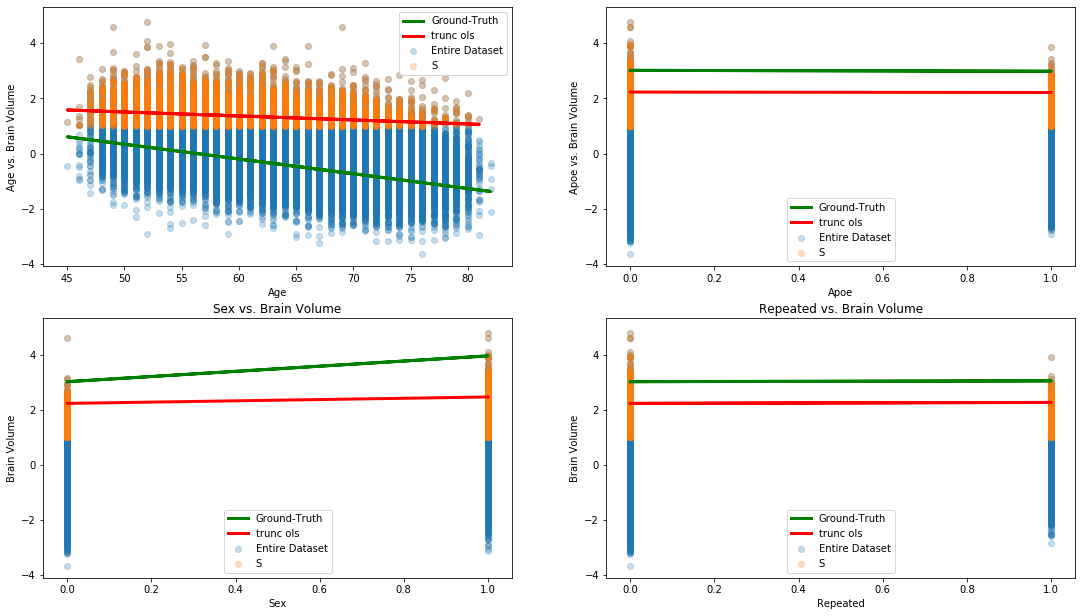

In [14]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)

# plot age vs brain volume
ax[0, 0].scatter(X[:,0], y, alpha=.25, label='Entire Dataset')
ax[0, 0].scatter(x_trunc[:,0], y_trunc, alpha=.25, label='S')
ax[0, 0].plot(X[:,0], X[:,0] * gt_ols.coef_[0, 0] + gt_ols.intercept_, label='Ground-Truth', linewidth=3.0, color='green')
ax[0, 0].plot(x_trunc[:,0], x_trunc[:,0] * trunc_ols.coef_[0, 0] + trunc_ols.intercept_, label='trunc ols', linewidth=3.0, color='red')
ax[0, 0].set_xlabel('Age')
ax[0, 0].set_ylabel('Brain Volume')
ax[0, 0].set_ylabel('Age vs. Brain Volume')
ax[0, 0].legend()

# plot apoe vs brain volume
ax[0, 1].scatter(X[:,1], y, alpha=.25, label='Entire Dataset')
ax[0, 1].scatter(x_trunc[:,1], y_trunc, alpha=.25, label='S')
ax[0, 1].plot(X[:,1], X[:,1] * gt_ols.coef_[0, 1] + gt_ols.intercept_, label='Ground-Truth', linewidth=3.0, color='green')
ax[0, 1].plot(x_trunc[:,1], x_trunc[:,1] * trunc_ols.coef_[0, 1] + trunc_ols.intercept_, label='trunc ols', linewidth=3.0, color='red')
ax[0, 1].set_xlabel('Apoe')
ax[0, 1].set_ylabel('Brain Volume')
ax[0, 1].set_ylabel('Apoe vs. Brain Volume')
ax[0, 1].legend()

# plot sex vs brain volume
ax[1, 0].scatter(X[:,2], y, alpha=.25, label='Entire Dataset')
ax[1, 0].scatter(x_trunc[:,2], y_trunc, alpha=.25, label='S')
ax[1, 0].plot(X[:,2], X[:,2] * gt_ols.coef_[0, 2] + gt_ols.intercept_, label='Ground-Truth', linewidth=3.0, color='green')
ax[1, 0].plot(x_trunc[:,2], x_trunc[:,2] * trunc_ols.coef_[0, 2] + trunc_ols.intercept_, label='trunc ols', linewidth=3.0, color='red')
ax[1, 0].set_xlabel('Sex')
ax[1, 0].set_ylabel('Brain Volume')
ax[1, 0].set_title('Sex vs. Brain Volume')
ax[1, 0].legend()

# plot repeated vs brain volume
ax[1, 1].scatter(X[:,3], y, alpha=.25, label='Entire Dataset')
ax[1, 1].scatter(x_trunc[:,3], y_trunc, alpha=.25, label='S')
ax[1, 1].plot(X[:,3], X[:,3] * gt_ols.coef_[0, 3] + gt_ols.intercept_, label='Ground-Truth', linewidth=3.0, color='green')
ax[1, 1].plot(x_trunc[:,3], x_trunc[:,3] * trunc_ols.coef_[0, 3] + trunc_ols.intercept_, label='trunc ols', linewidth=3.0, color='red')
ax[1, 1].set_xlabel('Repeated')
ax[1, 1].set_ylabel('Brain Volume')
ax[1, 1].set_title('Repeated vs. Brain Volume')
ax[1, 1].legend()
plt.show()

In [16]:
run_experiment(args, X, y)

# Plot Results

In [17]:
reader = CollectionReader(args.out_dir + args.exp)
logs = reader.df('logs')
logs.head()

100%|██████████| 9/9 [00:00<00:00, 104.95it/s]

,known_r2,known_param_mse,known_epsilon,known_time,unknown_param_mse,unknown_var_l1,unknown_epsilon,unknown_r2,unknown_time,ols_r2,...,ols_epsilon,trunc_reg_param_mse,trunc_reg_var_l1,trunc_reg_epsilon,trunc_reg_r2,trunc_reg_time,alpha,c,num_samples,exp_id
0,0.331110,0.328846,0.328846,10,0.027377,0.058435,0.085812,0.356707,19,0.355577,...,0.102112,0.022339,0.018335,0.040674,0.356595,1,0.985002,-2.00,35400,c69ff8d4-c16a-44c4-ba8d-b34a51c4bd6c
1,0.293581,0.484738,0.484738,9,0.034732,0.125494,0.160226,0.348256,15,0.297350,...,0.433347,0.045953,0.061986,0.107940,0.351098,1,0.847853,-1.00,30471,c69ff8d4-c16a-44c4-ba8d-b34a51c4bd6c
2,0.241051,0.581507,0.581507,7,0.088921,0.172569,0.261490,0.317225,12,0.153068,...,0.617331,0.063701,0.089617,0.153319,0.342265,1,0.690058,-0.50,24800,c69ff8d4-c16a-44c4-ba8d-b34a51c4bd6c
3,0.147172,0.665233,0.665233,5,0.104546,0.235544,0.340090,0.308258,9,-0.183786,...,0.766164,0.077609,0.118729,0.196339,0.330281,1,0.495312,0.00,17801,c69ff8d4-c16a-44c4-ba8d-b34a51c4bd6c
4,0.075099,0.677409,0.677409,4,0.066379,0.203128,0.269507,0.313778,7,-0.451078,...,0.818877,0.091411,0.146415,0.237827,0.310597,0,0.399121,0.25,14344,c69ff8d4-c16a-44c4-ba8d-b34a51c4bd6c


In [243]:
# logs['unknown_param_mse'] = logs['unknown_param_mse'] ** (.5)
# logs['known_param_mse'] = logs['known_param_mse'] ** (.5)
# logs['trunc_reg_param_mse'] = logs['trunc_reg_param_mse'] ** (.5)
# logs['ols_param_mse'] = logs['ols_param_mse'] ** (.5)

# logs['unknown_epsilon'] = logs['unknown_param_mse'] + logs['unknown_var_l1']
# logs['known_epsilon'] = logs['known_param_mse']
# logs['trunc_reg_epsilon'] = logs['trunc_reg_param_mse'] + logs['trunc_reg_var_l1']
# logs['ols_epsilon'] = logs['ols_param_mse'] + logs['ols_var_l1']

In [267]:
logs = logs[logs.exp_id == '7cc095c3-09e4-496d-aadb-9c78416018f7']

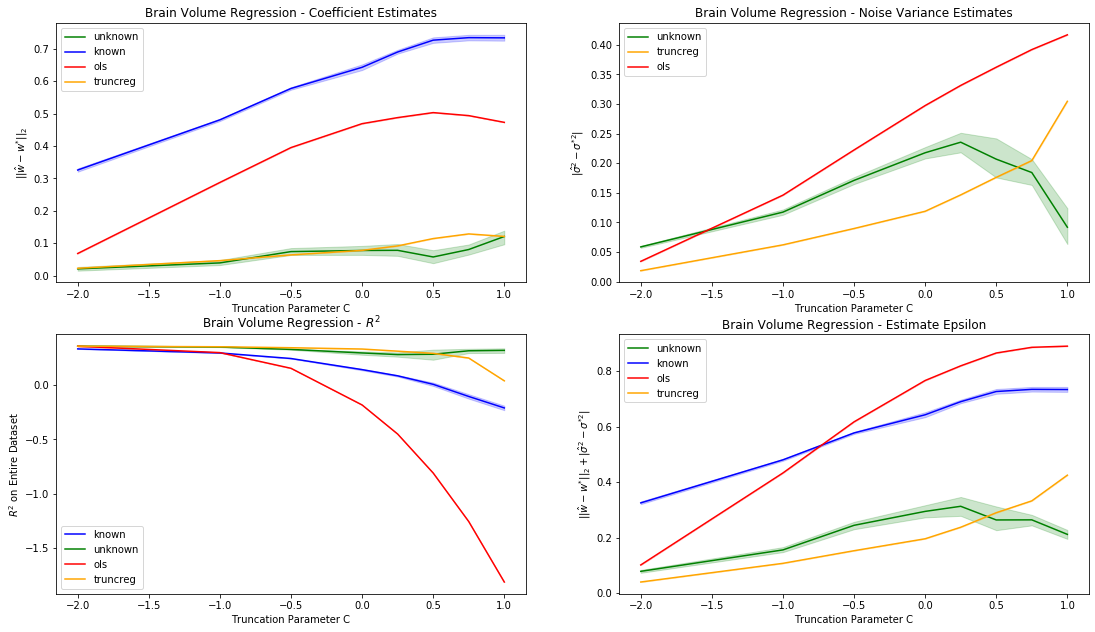

In [18]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)
# plot results for regression parameter MSE
sns.lineplot(data=logs, x='c', y='unknown_param_mse', label='unknown', color='green', ax=ax[0,0])
sns.lineplot(data=logs, x='c', y='known_param_mse', color='blue', label='known', ax=ax[0,0])
sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols', color='red', ax=ax[0,0])
sns.lineplot(data=logs, x='c', y='trunc_reg_param_mse', label='truncreg', color='orange', ax=ax[0,0])
ax[0,0].set_xlabel('Truncation Parameter C')
ax[0,0].set_ylabel('$||\hat w - w^{*}||_{2}$')
ax[0,0].set_title('Brain Volume Regression - Coefficient Estimates')

# plot results for regression noise variance l1
sns.lineplot(data=logs, x='c', y='unknown_var_l1', label='unknown', color="green", ax=ax[0,1])
sns.lineplot(data=logs, x='c', y='trunc_reg_var_l1', label='truncreg', color='orange', ax=ax[0,1])
sns.lineplot(data=logs, x='c', y='ols_var_l1', label='ols', color="red", ax=ax[0,1])
ax[0,1].set_xlabel('Truncation Parameter C')
ax[0,1].set_ylabel('$|\hat \sigma^{2} - \sigma^{*2}|$')
ax[0,1].set_title('Brain Volume Regression - Noise Variance Estimates')

# plot results for regression R^2
sns.lineplot(data=logs, x='c', y='known_r2', label='known', color='blue', ax=ax[1,0])
sns.lineplot(data=logs, x='c', y='unknown_r2', label='unknown', color='green', ax=ax[1,0])
sns.lineplot(data=logs, x='c', y='ols_r2', label='ols', color='red', ax=ax[1,0])
sns.lineplot(data=logs, x='c', y='trunc_reg_r2', label='truncreg', color='orange', ax=ax[1,0])
ax[1,0].set_xlabel('Truncation Parameter C')
ax[1,0].set_ylabel('$R^{2}$ on Entire Dataset')
ax[1,0].set_title('Brain Volume Regression - $R^{2}$')

# plot results for regression parameter epsilon 
sns.lineplot(data=logs, x='c', y='unknown_epsilon', label='unknown', color='green', ax=ax[1,1])
sns.lineplot(data=logs, x='c', y='known_epsilon', color='blue', label='known', ax=ax[1,1])
sns.lineplot(data=logs, x='c', y='ols_epsilon', label='ols', color='red', ax=ax[1,1])
sns.lineplot(data=logs, x='c', y='trunc_reg_epsilon', label='truncreg', color='orange', ax=ax[1,1])
ax[1,1].set_xlabel('Truncation Parameter C')
ax[1,1].set_ylabel('$||\hat w - w^{*}||_{2} + |\hat \sigma^{2} - \sigma^{*2}|$')
ax[1,1].set_title('Brain Volume Regression - Estimate Epsilon')
plt.show()